# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
#import the required libraries
import numpy as np
import os
from scipy.misc import imread, imresize
import imageio
import datetime
import os
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import glob
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Wrapper , Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, Input
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.applications import VGG16

Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
TRAIN_FOLDER = "Project_data/train"
VAL_FOLDER = "Project_data/val"

In [12]:
# plotting some random 10 images
# Input: train: True/False, dir_idx: index of directory inside train/val folder, idx: range of files inside the chosen folder
def print_sample_images(train=True, dir_idx=0, idx = range(0,30,3)):
    if(train):
        source = TRAIN_FOLDER
    else:
        source = VAL_FOLDER
        
    chosen_dir = os.listdir(source)[dir_idx]
    path = source+"/"+chosen_dir

    fig = plt.figure(figsize=(10,20))
    k=0
    for i in idx:
        image = imageio.imread(path+"/"+sorted(os.listdir(path))[i])
        ax = fig.add_subplot(6, 5, 1 + k, xticks=[], yticks=[])
        ax.set_title(i)
        plt.imshow(image)
        k+=1
    plt.show()

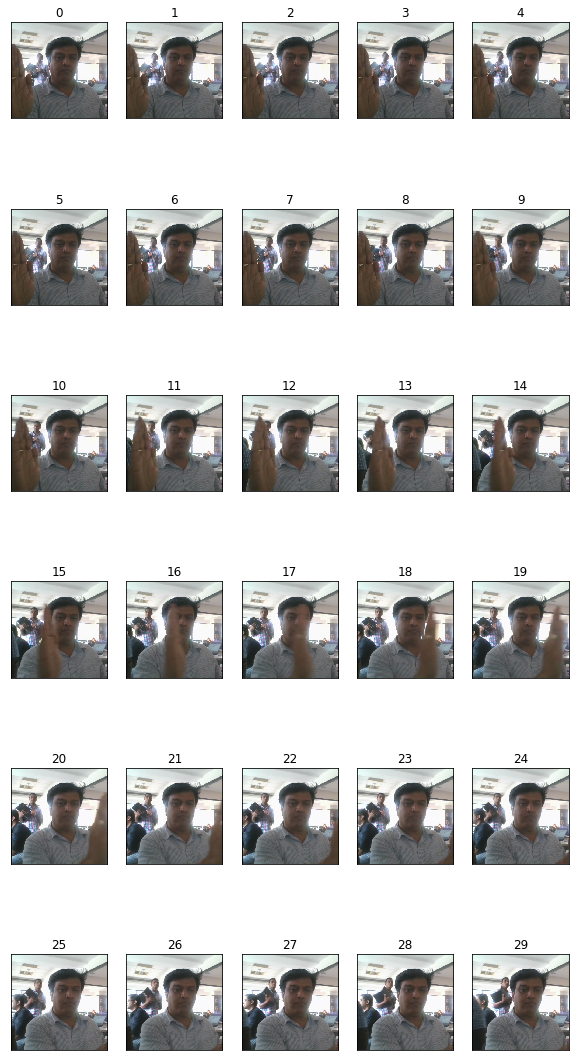

In [13]:
# It is evident that first 5 images and last 5 is required; in the middle not much changes so skipped images is sufficient
print_sample_images(True,4,range(0,30))

In [14]:
#function to identify the different dimensions of images in our video sequences in train folder
train_shapes_dict = {}
i=0
for folder in glob.iglob(TRAIN_FOLDER+'/*', recursive=True):
    img_path = next(glob.iglob(folder+'/*.png'))
    image = imageio.imread(img_path)
    if(image.shape in train_shapes_dict.keys()):
        train_shapes_dict[image.shape].append(folder)
    else:
        train_shapes_dict[image.shape] = [folder]
        
#function to identify the different dimensions of images in our video sequences in train folder
val_shapes_dict = {}
i=0
for folder in glob.iglob(VAL_FOLDER+'/*', recursive=True):
    img_path = next(glob.iglob(folder+'/*.png'))
    image = imageio.imread(img_path)
    if(image.shape in val_shapes_dict.keys()):
        val_shapes_dict[image.shape].append(folder)
    else:
        val_shapes_dict[image.shape] = [folder]

In [15]:
print("Dimensions of images in Train folder is",train_shapes_dict.keys())
print("\nDimensions of images in Val folder is",val_shapes_dict.keys())

Dimensions of images in Train folder is dict_keys([(120, 160, 3), (360, 360, 3)])

Dimensions of images in Val folder is dict_keys([(360, 360, 3), (120, 160, 3)])



actual 360*360 image



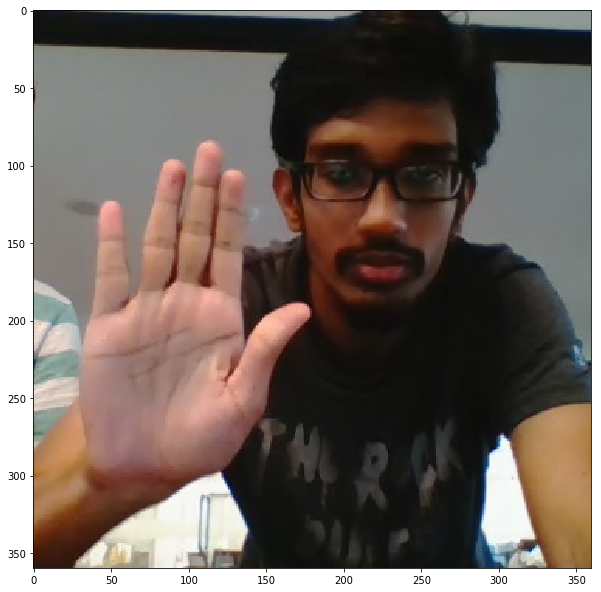


Image dimension below is 50 * 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


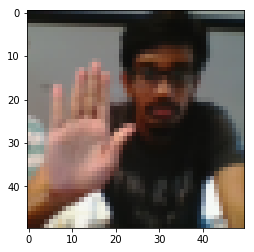


Image dimension below is 60 * 60


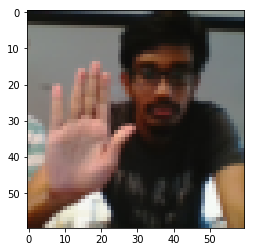


Image dimension below is 70 * 70


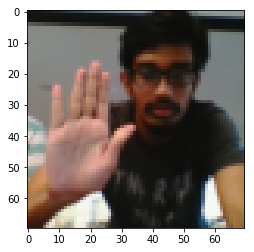


Image dimension below is 80 * 80


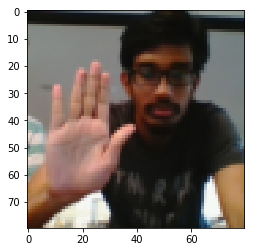


Image dimension below is 90 * 90


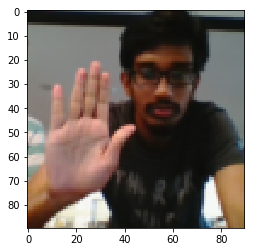

In [16]:
#Testing lower dimension sizes on original 360*360 image
#It is evident that images of resolution 70*70 and 80*80 are reasonable for our problem statement as hand is still recognisable
print("\nactual 360*360 image\n")
fig = plt.figure(figsize=(10,20))
temp_image = imageio.imread(next(glob.iglob(train_shapes_dict[(360, 360, 3)][0]+'/*.png')))
imshow(temp_image)
plt.show()
k=0
for i in range(50,100,10):
    image = imresize(temp_image, (i,i))
    ax = fig.add_subplot(6,5,1+k)
    print("\nImage dimension below is",i,"*",i)
    #ax.set_title(i)
    plt.imshow(image)
    k+=1
    plt.show()


Actual 120*160 image



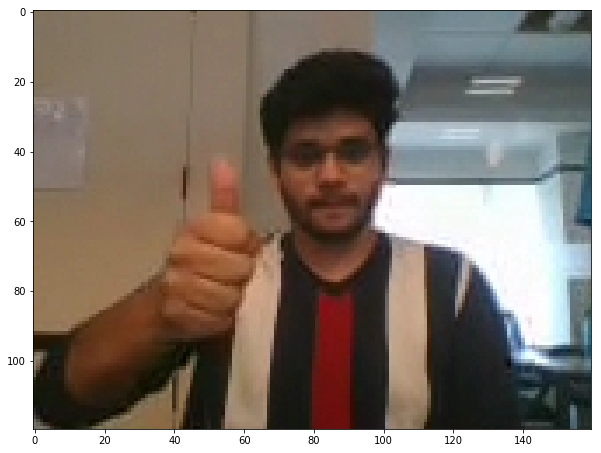


Cropped image to 120*120 



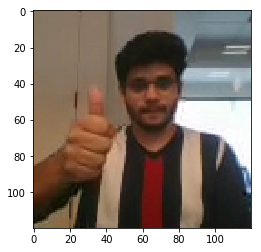

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app



Image dimension below is 50 * 50


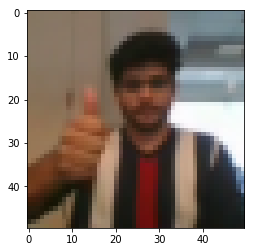


Image dimension below is 60 * 60


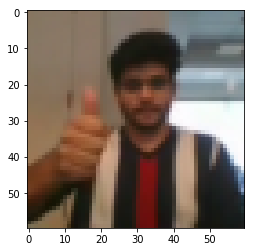


Image dimension below is 70 * 70


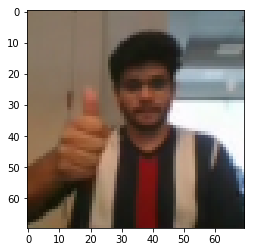


Image dimension below is 80 * 80


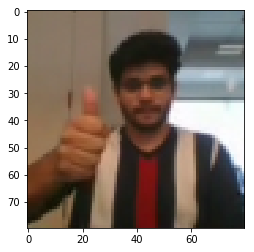


Image dimension below is 90 * 90


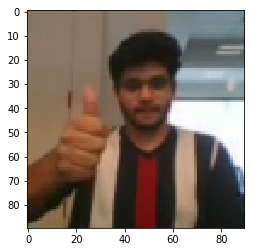

In [17]:
#Testing lower dimension sizes on cropped version (120*120) of original 120*160 image
#It is evident that images of resolution 70*70 and 80*80 are reasonable for our problem statement as hand is still recognisable
#Also tested on the cropped image - 120*120 since for resize the image dimensions should be of same rows and columns.
print("\nActual 120*160 image\n")
fig = plt.figure(figsize=(10,20))
temp_image = imageio.imread(next(glob.iglob(train_shapes_dict[(120, 160, 3)][0]+'/*.png')))
imshow(temp_image)
plt.show()
print("\nCropped image to 120*120 \n")
temp_image = temp_image[:,20:140,:]
imshow(temp_image)
plt.show()
k=0
for i in range(50,100,10):
    image = imresize(temp_image, (i,i))
    ax = fig.add_subplot(6,5,1+k)
    print("\nImage dimension below is",i,"*",i)
    plt.imshow(image)
    k+=1
    plt.show()

In [18]:
def normalize_image(img):
    norm_img = np.zeros(img.shape)
    for i in range(3):
        ci = img[:,:,i]
        ci_max = np.percentile(ci,95)
        ci_min = np.percentile(ci,5)
        norm_img[:,:,i] = (ci - ci_min)/(ci_max - ci_min) 
    return norm_img

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
#Selecting image dimensions as 70*70 
fixed_shape_transform = (70,70)

#Selecting input image frames as first 5, last 5 and every 3rd images between 6th to 25th images.
img_idx = [0, 1, 2, 3] + list(range(4, 25, 3)) + [25, 26, 27, 28, 29]
#img_idx = list(range(0,30))
print("Index of images in every video being choosen for model is", img_idx)

nr_imgs_per_vid = len(img_idx)
height = fixed_shape_transform[0]
width  = fixed_shape_transform[1]  

Index of images in every video being choosen for model is [0, 1, 2, 3, 4, 7, 10, 13, 16, 19, 22, 25, 26, 27, 28, 29]


In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size) 
    while True:
        t = np.random.permutation(folder_list)
        num_folders = len(folder_list)
        num_batches = int(num_folders / batch_size) # Derive from folder_list size and batch_size
        last_batch_size = int(num_folders % batch_size) # Derive from folder_list size and batch_size
        
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size, nr_imgs_per_vid, height, width,3)) 
            # nr_imgs_per_vid is the number of images you use for each video, 
            #(height, width) is the final size of the input images and 3 is the number of channels RGB
            
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                # read all the images in the folder
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if (image.shape == (120,160)):
                        image = image[:,20:140,:]
                    
                    image = imresize(image,(fixed_shape_transform))
                    
                    norm_img = normalize_image(image)
                    
                    batch_data[folder,idx,:,:,0] = norm_img[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = norm_img[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = norm_img[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

            
        # write the code for the remaining data points which are left after full batches            
        #Start - Send the remaining folders as the last batch
        batch_data = np.zeros((last_batch_size, nr_imgs_per_vid, height, width,3)) 
        batch_labels = np.zeros((last_batch_size, 5)) 
        
        
        for folder in range(last_batch_size): # iterate over the last_batch_size
            # read all the images in the folder
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            
            for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                #crop the images and resize them. Note that the images are of 2 different shape 
                if (image.shape == (120,160)):
                    image = image[:,20:140,:]

                image = imresize(image,(fixed_shape_transform))

                norm_img = normalize_image(image)

                batch_data[folder,idx,:,:,0] = norm_img[:,:,0] #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = norm_img[:,:,1] #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = norm_img[:,:,2] #normalise and feed in the image

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels
        #End - Send the remaining folders as the last batch
        

In [19]:
#THIS IS ONLY FOR TESTING THE LAST BATCH
#batch size and contents is tested here; when we give batch_size as 650, it shows that 'next' call will give last batch size 13
img_gen = generator(TRAIN_FOLDER, train_doc, batch_size=650)

batch_data, batch_labels = next(img_gen)
print("Shape of batch_data is", batch_data.shape)
print("Shape of batch_labels is", batch_labels.shape)

batch_data, batch_labels = next(img_gen)
print("Shape of last batch_data is", batch_data.shape)
print("Shape of last batch_labels is", batch_labels.shape)

print("printing the last batch_labels\n",batch_labels)

Source path =  Project_data/train ; batch size = 650


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Shape of batch_data is (650, 16, 70, 70, 3)
Shape of batch_labels is (650, 5)


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Shape of last batch_data is (13, 16, 70, 70, 3)
Shape of last batch_labels is (13, 5)
printing the last batch_labels
 [[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

### Model 
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
# this function is convenient to setup required parameters so we can experiement different models without repeating these steps
def model_params(batch_size, numberofepochs):
    global num_epochs, steps_per_epoch, validation_steps, curr_dt_time, train_path, val_path, num_train_sequences, num_val_sequences, model_name, filepath, checkpoint, LR, EarlyStop, callbacks_list, train_generator, val_generator
    curr_dt_time = datetime.datetime.now()
    train_path = TRAIN_FOLDER
    val_path = VAL_FOLDER
    num_train_sequences = len(train_doc)
    num_val_sequences = len(val_doc)
    num_epochs = numberofepochs 
    
    
    #The `steps_per_epoch`&`validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    print('num_train_sequences: ', num_train_sequences)    
    print('num_val_sequences: ', num_val_sequences)  
    print ('# of epochs:', num_epochs)
    print('batch_size: ', batch_size)  
    print('steps_per_epoch: ', steps_per_epoch)    
    print('validation_steps: ', validation_steps)
    
    #setting up other model parameters and callback lists.
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(model_name):
        os.mkdir(model_name)
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
    LR = ReduceLROnPlateau(monitor='val_loss', patience=2, cooldown=0) # write the REducelronplateau code here
    EarlyStop = EarlyStopping(patience = 4) 
    callbacks_list = [EarlyStop, LR, checkpoint]
    
    # Let us create the train_generator and the val_generator which will be used in .fit_generator.
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
 
    return

# Experiments

### Model 1

In [42]:
#experiment with the batch size and epochs
model_params(10, 10)

model1 = Sequential()

model1.add(Conv3D(32, 
                 kernel_size=(3, 3, 3), 
                 input_shape=(nr_imgs_per_vid, height, width,3), 
                 padding='same',
                 activation='relu'
                ))
model1.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))


model1.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same',activation='relu'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model1.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same',activation='relu'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(5, activation='softmax'))

num_train_sequences:  663
num_val_sequences:  100
# of epochs: 10
batch_size:  10
steps_per_epoch:  67
validation_steps:  10


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [43]:
optimiser = 'adam'
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 16, 70, 70, 32)    2624      
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 8, 35, 35, 32)     0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 8, 35, 35, 64)     55360     
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 4, 18, 18, 64)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 4, 18, 18, 128)    221312    
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 2, 9, 9, 128)      0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 20736)             0         
__________

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 10
Source path =  trainEpoch 1/10
 ; batch size = 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


66/67 [============================>.] - ETA: 2s - loss: 1.6507 - categorical_accuracy: 0.2182

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 148s 2s/step - loss: 1.6503 - categorical_accuracy: 0.2150 - val_loss: 1.6106 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.61058, saving model to model_init_2019-03-1706_44_05.862447/model-00001-1.65060-0.21719-1.61058-0.23000.h5
Epoch 2/10
66/67 [============================>.] - ETA: 0s - loss: 1.5973 - categorical_accuracy: 0.2591

### Model 2

In [8]:
#experiment with the batch size and epochs
model_params(16, 10)

num_train_sequences:  663
num_val_sequences:  100
# of epochs: 10
batch_size:  16
steps_per_epoch:  42
validation_steps:  7


In [9]:
model2 = Sequential()

model2.add(Conv3D(32, 
                 kernel_size=(3, 3, 3), 
                 input_shape=(nr_imgs_per_vid, height, width,3), 
                 padding='same',
                ))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))


model2.add(Conv3D(64, kernel_size=(3, 3, 3),
                 padding='same',
                ))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model2.add(Conv3D(128, kernel_size=(3, 3, 3),
                 padding='same',
                ))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(5, activation='softmax'))

optimiser = 'adam'
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 70, 70, 32)    2624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 70, 70, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 70, 70, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 35, 35, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 35, 35, 64)     55360     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 35, 35, 64)     256       
_________________________________________________________________
activation_2 (Activation)    (None, 8, 35, 35, 64)     0         
__________

In [10]:
model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 16
Source path =  train ; batch size = 16
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 6/42 [===>..........................] - ETA: 1:18 - loss: 12.2478 - categorical_accuracy: 0.1354

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


42/42 [==============================] - 57s 1s/step - loss: 12.7216 - categorical_accuracy: 0.1958 - val_loss: 12.5721 - val_categorical_accuracy: 0.2200

Epoch 00001: val_loss improved from inf to 12.57211, saving model to model_init_2019-03-1706_48_28.507825/model-00001-12.73763-0.19457-12.57211-0.22000.h5
Epoch 2/10
42/42 [==============================] - 50s 1s/step - loss: 12.9148 - categorical_accuracy: 0.1987 - val_loss: 12.4109 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss improved from 12.57211 to 12.41093, saving model to model_init_2019-03-1706_48_28.507825/model-00002-12.93337-0.19759-12.41093-0.23000.h5
Epoch 3/10
42/42 [==============================] - 51s 1s/step - loss: 12.8367 - categorical_accuracy: 0.2036 - val_loss: 12.7333 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 12.41093
Epoch 4/10
42/42 [==============================] - 52s 1s/step - loss: 12.9689 - categorical_accuracy: 0.1954 - val_loss: 12.4109 - val_catego

### Model 3

In [11]:
#experiment with the batch size and epochs
model_params(10, 10)

num_train_sequences:  663
num_val_sequences:  100
# of epochs: 10
batch_size:  10
steps_per_epoch:  67
validation_steps:  10


In [12]:
model3 = Sequential()

model3.add(Conv3D(32, 
                 kernel_size=(3, 3, 3), 
                 input_shape=(nr_imgs_per_vid, height, width,3), 
                 border_mode='same',
                ))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2), border_mode='same'))


model3.add(Conv3D(64, kernel_size=(3, 3, 3),
                 border_mode='same',
                ))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2), border_mode='same'))

model3.add(Conv3D(128, kernel_size=(3, 3, 3),
                 border_mode='same',
                ))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2), border_mode='same'))

model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(5, activation='softmax'))

optimiser = 'adam'
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, kernel_size=(3, 3, 3), input_shape=(16, 70, 7..., padding="same")`
  
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(2, 2, 2), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, kernel_size=(3, 3, 3), padding="same")`
  
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(2, 2, 2), padding="same")`
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv3D` call to the Keras 2 API:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 70, 70, 32)    2624      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 70, 70, 32)    128       
_________________________________________________________________
activation_4 (Activation)    (None, 16, 70, 70, 32)    0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 35, 35, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 35, 35, 64)     55360     
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 35, 35, 64)     256       
_________________________________________________________________
activation_5 (Activation)    (None, 8, 35, 35, 64)     0         
__________

In [ ]:
model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 10
Source path =  trainEpoch 1/10 ; batch size = 10



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


66/67 [============================>.] - ETA: 0s - loss: 12.6965 - categorical_accuracy: 0.2000

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 52s 779ms/step - loss: 12.7470 - categorical_accuracy: 0.1970 - val_loss: 12.7333 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 12.73330, saving model to model_init_2019-03-1706_56_10.320635/model-00001-12.71198-0.19910-12.73330-0.21000.h5
Epoch 2/10
66/67 [============================>.] - ETA: 0s - loss: 12.7968 - categorical_accuracy: 0.2061

### Model 4

In [ ]:
#experiment with the batch size and epochs
model_params(10, 10)

In [ ]:
#70x70 without BN

model4 = Sequential()

model4.add(Conv3D(32, 
                 kernel_size=(3, 3, 3), 
                 input_shape=(nr_imgs_per_vid, height, width,3), 
                 border_mode='same',
                ))
#model3.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2), border_mode='same'))


model4.add(Conv3D(64, kernel_size=(3, 3, 3),
                 border_mode='same',
                ))
#model3.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2), border_mode='same'))

model4.add(Conv3D(128, kernel_size=(3, 3, 3),
                 border_mode='same',
                ))
#model3.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2), border_mode='same'))

model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(5, activation='softmax'))

optimiser = 'adam'
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

In [ ]:
model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Model 5

In [ ]:
#experiment with the batch size and epochs
model_params(16, 15) 

In [ ]:
#70x70 without BN and all images, batch size is 16 and epochs is 15

model5 = Sequential()

model5.add(Conv3D(32, 
                 kernel_size=(3, 3, 3), 
                 input_shape=(nr_imgs_per_vid, height, width,3), 
                 border_mode='same',
                ))
#model3.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2), border_mode='same'))


model5.add(Conv3D(64, kernel_size=(3, 3, 3),
                 border_mode='same',
                ))
#model3.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2), border_mode='same'))

model5.add(Conv3D(128, kernel_size=(3, 3, 3),
                 border_mode='same',
                ))
#model3.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2), border_mode='same'))

model5.add(Flatten())
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(5, activation='softmax'))

optimiser = 'adam'
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

In [ ]:
model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Model 6a

In [12]:
#experiment with the batch size and epochs
model_params(16, 15)

num_train_sequences:  663
num_val_sequences:  100
batch_size:  16
steps_per_epoch:  42
validation_steps:  7


In [ ]:
def get_vgg(net_shape):
    vgg = VGG16( weights="imagenet", include_top = False, input_shape= net_shape)
    outputs = vgg.layers[9].output
    return Model(vgg.input, outputs)

In [ ]:
vgg = get_vgg((fixed_shape_transform[0], fixed_shape_transform[1],3))
vgg.summary()

In [ ]:
def get_CNN_LSTM_model():

    vgg = get_vgg((fixed_shape_transform[0], fixed_shape_transform[1],3))
    input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
    
    input_layer = Input(shape=input_shape)
    x = TimeDistributed(vgg)(input_layer)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(32)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(5, activation='softmax')(x)
    
    model = Model(input_layer,x)
    return model

In [ ]:
model6a = get_CNN_LSTM_model()
optimiser = 'adam'
model6a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6a.summary())

In [ ]:
model6a.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

### Model 6b

In [ ]:
#experiment with the batch size and epochs
model_params(16, 15)

In [54]:
def get_vgg(net_shape):
    vgg = VGG16( weights="imagenet", include_top = False, input_shape= net_shape)
    outputs = vgg.layers[14].output

    return Model(vgg.input, outputs)

In [55]:
vgg = get_vgg((fixed_shape_transform[0], fixed_shape_transform[1],3))
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 70, 70, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 70, 70, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 70, 70, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 35, 35, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 35, 35, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 35, 35, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 17, 17, 128)       0         
__________

In [58]:
def get_CNN_LSTM_model():

    vgg = get_vgg((fixed_shape_transform[0], fixed_shape_transform[1],3))
    input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
    
    input_layer = Input(shape=input_shape)
    x = TimeDistributed(vgg)(input_layer)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(5, activation='softmax')(x)
    
    model = Model(input_layer,x)
    return model

In [59]:
model6b = get_CNN_LSTM_model()
optimiser = 'adam'
model6b.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6b.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_40 (TimeDis (None, 16, 4, 4, 512)     7635264   
_________________________________________________________________
time_distributed_41 (TimeDis (None, 16, 8192)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 16, 64)            2113792   
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_13 (Dense)             (None, 512)               33280     
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
__________

In [60]:
model6b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Source path =  Project_data/train ; batch size = 16
Epoch 1/15Project_data/val ; batch size = 16



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


42/42 [==============================] - 65s 2s/step - loss: 1.6328 - categorical_accuracy: 0.2036 - val_loss: 1.6111 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss did not improve from 1.00000
Epoch 2/15
42/42 [==============================] - 50s 1s/step - loss: 1.6135 - categorical_accuracy: 0.1887 - val_loss: 1.6091 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 1.00000
Epoch 3/15
42/42 [==============================] - 55s 1s/step - loss: 1.6148 - categorical_accuracy: 0.1943 - val_loss: 1.6066 - val_categorical_accuracy: 0.2200

Epoch 00003: val_loss did not improve from 1.00000
Epoch 4/15
42/42 [==============================] - 54s 1s/step - loss: 1.6159 - categorical_accuracy: 0.2028 - val_loss: 1.6090 - val_categorical_accuracy: 0.2300

Epoch 00004: val_loss did not improve from 1.00000
Epoch 5/15
42/42 [==============================] - 54s 1s/step - loss: 1.6116 - categorical_accuracy: 0.2017 - val_loss: 1.6055 - val_categorical_

### Model 7

In [ ]:
#experiment with the batch size and epochs
model_params(16,15)

In [49]:
input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                 activation='relu'
                ))(input_layer)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(64, return_sequences=True)(x)
x = LSTM(64)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model7 = Model(input_layer,x)

In [50]:
optimiser = 'adam'
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 16, 35, 35, 64)    18496     
_________________________________________________________________
time_distributed_35 (TimeDis (None, 16, 18, 18, 64)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 16, 18, 18, 128)   73856     
_________________________________________________________________
time_distributed_37 (TimeDis (None, 16, 9, 9, 128)     0         
__________

In [51]:
model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 16
Source path =  Project_data/train ; batch size = 16
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 6/42 [===>..........................] - ETA: 1:10 - loss: 1.6300 - categorical_accuracy: 0.1667

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


42/42 [==============================] - 55s 1s/step - loss: 1.6195 - categorical_accuracy: 0.2125 - val_loss: 1.6070 - val_categorical_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 1.60699, saving model to model_init_2019-03-1515_13_43.463263/model-00001-1.61972-0.20965-1.60699-0.25000.h5
Epoch 2/15
42/42 [==============================] - 50s 1s/step - loss: 1.5882 - categorical_accuracy: 0.2557 - val_loss: 1.5006 - val_categorical_accuracy: 0.3000

Epoch 00002: val_loss improved from 1.60699 to 1.50057, saving model to model_init_2019-03-1515_13_43.463263/model-00002-1.58768-0.25339-1.50057-0.30000.h5
Epoch 3/15
42/42 [==============================] - 52s 1s/step - loss: 1.3239 - categorical_accuracy: 0.4470 - val_loss: 1.2514 - val_categorical_accuracy: 0.4800

Epoch 00003: val_loss improved from 1.50057 to 1.25138, saving model to model_init_2019-03-1515_13_43.463263/model-00003-1.33268-0.44344-1.25138-0.48000.h5
Epoch 4/15
42/42 [==============================] - 

### Model 8

In [ ]:
#experiment with the batch size and epochs
model_params(16,15)

In [19]:
input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                 activation='relu'
                ))(input_layer)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(128)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model8 = Model(input_layer,x)


In [20]:
optimiser = 'adam'
model8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 16, 35, 35, 64)    18496     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 16, 18, 18, 64)    0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 16, 18, 18, 128)   73856     
_________________________________________________________________
time_distributed_13 (TimeDis (None, 16, 9, 9, 128)     0         
__________

In [21]:
model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 16
Source path =  train ; batch size = 16
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 6/42 [===>..........................] - ETA: 1:04 - loss: 1.6200 - categorical_accuracy: 0.2083

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


42/42 [==============================] - 53s 1s/step - loss: 1.6217 - categorical_accuracy: 0.2024 - val_loss: 1.6054 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss did not improve from 1.07517
Epoch 2/15
42/42 [==============================] - 50s 1s/step - loss: 1.5688 - categorical_accuracy: 0.3085 - val_loss: 1.4576 - val_categorical_accuracy: 0.4000

Epoch 00002: val_loss did not improve from 1.07517
Epoch 3/15
42/42 [==============================] - 50s 1s/step - loss: 1.3853 - categorical_accuracy: 0.4183 - val_loss: 1.3711 - val_categorical_accuracy: 0.4400

Epoch 00003: val_loss did not improve from 1.07517
Epoch 4/15
42/42 [==============================] - 50s 1s/step - loss: 1.2876 - categorical_accuracy: 0.4686 - val_loss: 1.4896 - val_categorical_accuracy: 0.3800

Epoch 00004: val_loss did not improve from 1.07517
Epoch 5/15
42/42 [==============================] - 50s 1s/step - loss: 1.2830 - categorical_accuracy: 0.4931 - val_loss: 1.3431 - val_categorical_

### Model 9

In [13]:
#experiment with the batch size and epochs
model_params(16,15)

In [14]:
input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                 activation='relu'
                ))(input_layer)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(256, return_sequences=True)(x)
x = LSTM(256)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model9 = Model(input_layer,x)


In [15]:
optimiser = 'adam'
model9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model9.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 35, 35, 64)    18496     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 18, 18, 64)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 18, 18, 128)   73856     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 9, 9, 128)     0         
__________

In [16]:
model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 16
Source path =  train ; batch size = Epoch 1/15
16


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


42/42 [==============================] - 175s 4s/step - loss: 1.6306 - categorical_accuracy: 0.2073 - val_loss: 1.5879 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss improved from inf to 1.58791, saving model to model_init_2019-03-1605_38_27.842154/model-00001-1.63092-0.20814-1.58791-0.24000.h5
Epoch 2/15
42/42 [==============================] - 64s 2s/step - loss: 1.4992 - categorical_accuracy: 0.3323 - val_loss: 1.5652 - val_categorical_accuracy: 0.3200

Epoch 00002: val_loss improved from 1.58791 to 1.56521, saving model to model_init_2019-03-1605_38_27.842154/model-00002-1.49648-0.33484-1.56521-0.32000.h5
Epoch 3/15
42/42 [==============================] - 63s 1s/step - loss: 1.3749 - categorical_accuracy: 0.3893 - val_loss: 1.3440 - val_categorical_accuracy: 0.4100

Epoch 00003: val_loss improved from 1.56521 to 1.34399, saving model to model_init_2019-03-1605_38_27.842154/model-00003-1.37095-0.39065-1.34399-0.41000.h5
Epoch 4/15
42/42 [==============================] -

### Model 10

In [ ]:
#experiment with the batch size and epochs
model_params(16,15)

In [12]:
input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                 activation='relu'
                ))(input_layer)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(
                   Conv2D(256, 
                 kernel_size=(3, 3),  
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(128)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model10 = Model(input_layer,x)

optimiser = 'adam'
model10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model10.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 35, 35, 64)    18496     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 18, 18, 64)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 18, 18, 128)   73856     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 9, 9, 128)     0         
__________

In [13]:
model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 16
Source path =  train ; batch size = 16
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


42/42 [==============================] - 149s 4s/step - loss: 1.6336 - categorical_accuracy: 0.1969 - val_loss: 1.6094 - val_categorical_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.60939, saving model to model_init_2019-03-1606_15_52.676923/model-00001-1.63386-0.19759-1.60939-0.20000.h5
Epoch 2/15
42/42 [==============================] - 51s 1s/step - loss: 1.6114 - categorical_accuracy: 0.1794 - val_loss: 1.6104 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 1.60939
Epoch 3/15
42/42 [==============================] - 52s 1s/step - loss: 1.6113 - categorical_accuracy: 0.1909 - val_loss: 1.6075 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss improved from 1.60939 to 1.60745, saving model to model_init_2019-03-1606_15_52.676923/model-00003-1.61143-0.19155-1.60745-0.17000.h5
Epoch 4/15
42/42 [==============================] - 51s 1s/step - loss: 1.6120 - categorical_accuracy: 0.1682 - val_loss: 1.6085 - val_categorical_accuracy:

### Model 11

In [17]:
#experiment with the batch size and epochs
model_params(16,15)

num_train_sequences:  663
num_val_sequences:  100
batch_size:  16
steps_per_epoch:  42
validation_steps:  7


In [18]:
input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                 activation='relu'
                ))(input_layer)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(
                   Conv2D(256, 
                 kernel_size=(3, 3),  
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(128)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
#x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model11 = Model(input_layer,x)

optimiser = 'adam'
model11.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model11.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 35, 35, 64)    18496     
_________________________________________________________________
time_distributed_22 (TimeDis (None, 16, 18, 18, 64)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 16, 18, 18, 128)   73856     
_________________________________________________________________
time_distributed_24 (TimeDis (None, 16, 9, 9, 128)     0         
__________

In [19]:
model11.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  train ; batch size = 16
 val ; batch size = 16
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 6/42 [===>..........................] - ETA: 1:08 - loss: 1.6243 - categorical_accuracy: 0.2083

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


42/42 [==============================] - 55s 1s/step - loss: 1.6461 - categorical_accuracy: 0.1786 - val_loss: 1.6142 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.61417, saving model to model_init_2019-03-1606_15_52.676923/model-00001-1.64662-0.18100-1.61417-0.23000.h5
Epoch 2/15
42/42 [==============================] - 51s 1s/step - loss: 1.6164 - categorical_accuracy: 0.1831 - val_loss: 1.6084 - val_categorical_accuracy: 0.1900

Epoch 00002: val_loss improved from 1.61417 to 1.60840, saving model to model_init_2019-03-1606_15_52.676923/model-00002-1.61650-0.18552-1.60840-0.19000.h5
Epoch 3/15
42/42 [==============================] - 52s 1s/step - loss: 1.6102 - categorical_accuracy: 0.2062 - val_loss: 1.6081 - val_categorical_accuracy: 0.2300

Epoch 00003: val_loss improved from 1.60840 to 1.60813, saving model to model_init_2019-03-1606_15_52.676923/model-00003-1.61055-0.20513-1.60813-0.23000.h5
Epoch 4/15
42/42 [==============================] - 

### Model 12

In [11]:
#experiment with the batch size and epochs
model_params(16,15)

num_train_sequences:  663
num_val_sequences:  100
batch_size:  16
steps_per_epoch:  42
validation_steps:  7


In [12]:
input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                 activation='relu'
                ))(input_layer)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same',strides=(1, 1)))(x)
x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same',strides=(2, 2)))(x)
x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(4, 4),  
                 padding='same',
                 activation='relu'
                ))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same',strides=(2, 2)))(x)
x = TimeDistributed(Flatten())(x)
x = Dropout(0.5)(x)
x = LSTM(32, return_sequences=True)(x)
x = LSTM(32)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model12 = Model(input_layer,x)

optimiser = 'adam'
model12.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model12.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 70, 70, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 70, 70, 64)    18496     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 35, 35, 64)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 35, 35, 128)   131200    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 18, 18, 128)   0         
__________

In [13]:
model12.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  train ; batch size = 16
Epoch 1/15 val ; batch size = 16



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


42/42 [==============================] - 151s 4s/step - loss: 1.6152 - categorical_accuracy: 0.2132 - val_loss: 1.6107 - val_categorical_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.61069, saving model to model_init_2019-03-1606_58_17.093528/model-00001-1.61520-0.21418-1.61069-0.20000.h5
Epoch 2/15
42/42 [==============================] - 51s 1s/step - loss: 1.6216 - categorical_accuracy: 0.1969 - val_loss: 1.6074 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss improved from 1.61069 to 1.60740, saving model to model_init_2019-03-1606_58_17.093528/model-00002-1.62145-0.19759-1.60740-0.23000.h5
Epoch 3/15
42/42 [==============================] - 51s 1s/step - loss: 1.6155 - categorical_accuracy: 0.1898 - val_loss: 1.6097 - val_categorical_accuracy: 0.1800

Epoch 00003: val_loss did not improve from 1.60740
Epoch 4/15
42/42 [==============================] - 52s 1s/step - loss: 1.6114 - categorical_accuracy: 0.2158 - val_loss: 1.6069 - val_categorical_accuracy:

KeyboardInterrupt: 

### Model 13

In [18]:
#experiment with the batch size and epochs
model_params(16,15)

num_train_sequences:  663
num_val_sequences:  100
batch_size:  16
steps_per_epoch:  42
validation_steps:  7


In [19]:
batch_size = 16 
input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                ))(input_layer)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(Flatten())(x)
x = LSTM(256, return_sequences=True)(x)
x = LSTM(256)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model13 = Model(input_layer,x)
optimiser = 'adam'
model13.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model13.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 16, 70, 70, 32)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 16, 70, 70, 32)    128       
_________________________________________________________________
time_distributed_24 (TimeDis (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 16, 35, 35, 64)    18496     
_________________________________________________________________
time_distributed_26 (TimeDis (None, 16, 35, 35, 64)    0         
__________

In [20]:
model13.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  train ; batch size = 16
Epoch 1/15 val
 ; batch size = 16


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 6/42 [===>..........................] - ETA: 1:09 - loss: 1.6081 - categorical_accuracy: 0.2708

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


42/42 [==============================] - 55s 1s/step - loss: 1.5787 - categorical_accuracy: 0.2710 - val_loss: 1.4364 - val_categorical_accuracy: 0.3900

Epoch 00001: val_loss improved from inf to 1.43643, saving model to model_init_2019-03-1606_58_17.093528/model-00001-1.58353-0.26697-1.43643-0.39000.h5
Epoch 2/15
42/42 [==============================] - 50s 1s/step - loss: 1.3398 - categorical_accuracy: 0.4183 - val_loss: 1.6279 - val_categorical_accuracy: 0.4000

Epoch 00002: val_loss did not improve from 1.43643
Epoch 3/15
42/42 [==============================] - 50s 1s/step - loss: 1.2219 - categorical_accuracy: 0.4913 - val_loss: 1.3955 - val_categorical_accuracy: 0.3900

Epoch 00003: val_loss improved from 1.43643 to 1.39552, saving model to model_init_2019-03-1606_58_17.093528/model-00003-1.22242-0.49020-1.39552-0.39000.h5
Epoch 4/15
42/42 [==============================] - 50s 1s/step - loss: 1.0622 - categorical_accuracy: 0.5828 - val_loss: 1.0974 - val_categorical_accuracy: 

### Model 14

In [23]:
#experiment with the batch size and epochs
model_params(16,15)

num_train_sequences:  663
num_val_sequences:  100
batch_size:  16
steps_per_epoch:  42
validation_steps:  7


In [24]:
batch_size = 16 
input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                ))(input_layer)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(Flatten())(x)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(256)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model14 = Model(input_layer,x)
optimiser = 'adam'
model14.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model14.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_35 (TimeDis (None, 16, 70, 70, 32)    0         
_________________________________________________________________
time_distributed_36 (TimeDis (None, 16, 70, 70, 32)    128       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 16, 35, 35, 64)    18496     
_________________________________________________________________
time_distributed_39 (TimeDis (None, 16, 35, 35, 64)    0         
__________

In [25]:
model14.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 16
Source path =  train ; batch size = 16
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 6/42 [===>..........................] - ETA: 1:10 - loss: 1.6751 - categorical_accuracy: 0.1771

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


42/42 [==============================] - 54s 1s/step - loss: 1.5570 - categorical_accuracy: 0.2773 - val_loss: 1.5095 - val_categorical_accuracy: 0.3200

Epoch 00001: val_loss improved from inf to 1.50953, saving model to model_init_2019-03-1606_58_17.093528/model-00001-1.56318-0.27149-1.50953-0.32000.h5
Epoch 2/15
42/42 [==============================] - 49s 1s/step - loss: 1.2997 - categorical_accuracy: 0.4507 - val_loss: 1.1002 - val_categorical_accuracy: 0.5500

Epoch 00002: val_loss improved from 1.50953 to 1.10019, saving model to model_init_2019-03-1606_58_17.093528/model-00002-1.30526-0.45098-1.10019-0.55000.h5
Epoch 3/15
42/42 [==============================] - 51s 1s/step - loss: 1.1296 - categorical_accuracy: 0.5497 - val_loss: 1.2639 - val_categorical_accuracy: 0.4200

Epoch 00003: val_loss did not improve from 1.10019
Epoch 4/15
42/42 [==============================] - 50s 1s/step - loss: 0.9195 - categorical_accuracy: 0.6498 - val_loss: 1.1448 - val_categorical_accuracy: 

### Model 15

In [11]:
#experiment with the batch size and epochs
model_params(32, 15)

num_train_sequences:  663
num_val_sequences:  100
batch_size:  32
steps_per_epoch:  21
validation_steps:  4


In [12]:
input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                ))(input_layer)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(Flatten())(x)
x = GRU(128, return_sequences=True)(x)
x = GRU(128)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model15 = Model(input_layer,x)
optimiser = 'adam'
model15.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model15.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 70, 70, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 70, 70, 32)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 35, 35, 64)    18496     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 35, 35, 64)    0         
__________

In [13]:
model15.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 32
Source path =  Epoch 1/15
train ; batch size = 32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 146s 7s/step - loss: 1.5173 - categorical_accuracy: 0.3317 - val_loss: 1.3675 - val_categorical_accuracy: 0.4100

Epoch 00001: val_loss improved from inf to 1.36746, saving model to model_init_2019-03-1608_07_42.144742/model-00001-1.51712-0.33032-1.36746-0.41000.h5
Epoch 2/15
21/21 [==============================] - 52s 2s/step - loss: 1.2152 - categorical_accuracy: 0.5032 - val_loss: 1.2516 - val_categorical_accuracy: 0.4400

Epoch 00002: val_loss improved from 1.36746 to 1.25159, saving model to model_init_2019-03-1608_07_42.144742/model-00002-1.22008-0.50075-1.25159-0.44000.h5
Epoch 3/15
21/21 [==============================] - 50s 2s/step - loss: 0.9263 - categorical_accuracy: 0.6441 - val_loss: 1.5985 - val_categorical_accuracy: 0.4000

Epoch 00003: val_loss did not improve from 1.25159
Epoch 4/15
21/21 [==============================] - 49s 2s/step - loss: 0.7582 - categorical_accuracy: 0.7218 - val_loss: 1.8784 - val_categorical_accuracy:

### Model 16

In [11]:
#experiment with the batch size and epochs
model_params(32, 15)

num_train_sequences:  663
num_val_sequences:  100
batch_size:  32
steps_per_epoch:  21
validation_steps:  4


In [12]:
# running with batch_size as 32 
input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                ))(input_layer)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(256, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(Flatten())(x)
x = GRU(128, return_sequences=True)(x)
x = GRU(128)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model16 = Model(input_layer,x)
optimiser = 'adam'
model16.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model16.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 70, 70, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 70, 70, 32)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 35, 35, 64)    18496     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 35, 35, 64)    0         
__________

In [13]:
model16.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 32
Source path =  train ; batch size = 32
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 150s 7s/step - loss: 1.5152 - categorical_accuracy: 0.3238 - val_loss: 1.4693 - val_categorical_accuracy: 0.3600

Epoch 00001: val_loss improved from inf to 1.46929, saving model to model_init_2019-03-1608_43_23.093437/model-00001-1.51808-0.32127-1.46929-0.36000.h5
Epoch 2/15
21/21 [==============================] - 52s 2s/step - loss: 1.1317 - categorical_accuracy: 0.5515 - val_loss: 1.1150 - val_categorical_accuracy: 0.5100

Epoch 00002: val_loss improved from 1.46929 to 1.11499, saving model to model_init_2019-03-1608_43_23.093437/model-00002-1.13702-0.54902-1.11499-0.51000.h5
Epoch 3/15
21/21 [==============================] - 52s 2s/step - loss: 0.9383 - categorical_accuracy: 0.6482 - val_loss: 0.8929 - val_categorical_accuracy: 0.6500

Epoch 00003: val_loss improved from 1.11499 to 0.89289, saving model to model_init_2019-03-1608_43_23.093437/model-00003-0.94225-0.64706-0.89289-0.65000.h5
Epoch 4/15
21/21 [==============================] -

### Model 17

In [ ]:
#experiment with the batch size and epochs
model_params(32, 15)

In [12]:
# running with batch_size as 32 
input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                ))(input_layer)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(256, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(512, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(Flatten())(x)
x = GRU(128, return_sequences=True)(x)
x = GRU(128)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model17 = Model(input_layer,x)
optimiser = 'adam'
model17.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model17.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 70, 70, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 70, 70, 32)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 35, 35, 64)    18496     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 35, 35, 64)    0         
__________

In [13]:
model17.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 32
Source path =  train ; batch size = 32
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 155s 7s/step - loss: 1.5982 - categorical_accuracy: 0.2328 - val_loss: 1.3990 - val_categorical_accuracy: 0.3900

Epoch 00001: val_loss improved from inf to 1.39899, saving model to model_init_2019-03-1612_16_51.236433/model-00001-1.60059-0.23077-1.39899-0.39000.h5
Epoch 2/15
21/21 [==============================] - 51s 2s/step - loss: 1.3033 - categorical_accuracy: 0.4295 - val_loss: 1.3609 - val_categorical_accuracy: 0.3900

Epoch 00002: val_loss improved from 1.39899 to 1.36086, saving model to model_init_2019-03-1612_16_51.236433/model-00002-1.30532-0.42836-1.36086-0.39000.h5
Epoch 3/15
21/21 [==============================] - 51s 2s/step - loss: 1.0791 - categorical_accuracy: 0.5615 - val_loss: 2.1227 - val_categorical_accuracy: 0.2700

Epoch 00003: val_loss did not improve from 1.36086
Epoch 4/15
21/21 [==============================] - 50s 2s/step - loss: 0.9744 - categorical_accuracy: 0.5891 - val_loss: 1.6550 - val_categorical_accuracy:

### Model 18

In [16]:
#experiment with the batch size and epochs
model_params(32, 15)

num_train_sequences:  663
num_val_sequences:  100
batch_size:  32
steps_per_epoch:  21
validation_steps:  4


In [17]:
input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                ))(input_layer)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(256, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(512, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(Flatten())(x)
x = GRU(256, return_sequences=True)(x)
x = GRU(256)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model18 = Model(input_layer,x)
optimiser = 'adam'
model18.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model18.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_23 (TimeDis (None, 16, 70, 70, 32)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 16, 70, 70, 32)    128       
_________________________________________________________________
time_distributed_25 (TimeDis (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 16, 35, 35, 64)    18496     
_________________________________________________________________
time_distributed_27 (TimeDis (None, 16, 35, 35, 64)    0         
__________

In [18]:
model18.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 32
Source path =  train ; batch size = 32
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/21 [=>............................] - ETA: 1:23 - loss: 1.7985 - categorical_accuracy: 0.1875

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 60s 3s/step - loss: 1.6359 - categorical_accuracy: 0.2660 - val_loss: 1.5007 - val_categorical_accuracy: 0.3500

Epoch 00001: val_loss improved from inf to 1.50066, saving model to model_init_2019-03-1612_16_51.236433/model-00001-1.63657-0.26546-1.50066-0.35000.h5
Epoch 2/15
21/21 [==============================] - 49s 2s/step - loss: 1.4017 - categorical_accuracy: 0.3961 - val_loss: 1.2620 - val_categorical_accuracy: 0.4400

Epoch 00002: val_loss improved from 1.50066 to 1.26200, saving model to model_init_2019-03-1612_16_51.236433/model-00002-1.40134-0.39668-1.26200-0.44000.h5
Epoch 3/15
21/21 [==============================] - 51s 2s/step - loss: 1.0990 - categorical_accuracy: 0.5660 - val_loss: 1.4544 - val_categorical_accuracy: 0.4700

Epoch 00003: val_loss did not improve from 1.26200
Epoch 4/15
21/21 [==============================] - 51s 2s/step - loss: 0.8816 - categorical_accuracy: 0.6611 - val_loss: 2.3738 - val_categorical_accuracy: 

### Model 19

In [20]:
#experiment with the batch size and epochs
model_params(32, 15)

num_train_sequences:  663
num_val_sequences:  100
batch_size:  32
steps_per_epoch:  21
validation_steps:  4


In [21]:
input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                ))(input_layer)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(256, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)


x = TimeDistributed(Flatten())(x)
x = GRU(256, return_sequences=True)(x)
x = GRU(256)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model19 = Model(input_layer,x)
optimiser = 'adam'
model19.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model19.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_43 (TimeDis (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_44 (TimeDis (None, 16, 70, 70, 32)    0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 16, 70, 70, 32)    128       
_________________________________________________________________
time_distributed_46 (TimeDis (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, 16, 35, 35, 64)    18496     
_________________________________________________________________
time_distributed_48 (TimeDis (None, 16, 35, 35, 64)    0         
__________

In [ ]:
model19.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 32
Source path =  train ; batch size = 32
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/21 [=>............................] - ETA: 1:24 - loss: 1.7929 - categorical_accuracy: 0.2031

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 58s 3s/step - loss: 1.6234 - categorical_accuracy: 0.2860 - val_loss: 1.3200 - val_categorical_accuracy: 0.3800

Epoch 00001: val_loss improved from inf to 1.31999, saving model to model_init_2019-03-1612_16_51.236433/model-00001-1.62954-0.28356-1.31999-0.38000.h5
Epoch 2/15
21/21 [==============================] - 48s 2s/step - loss: 1.1295 - categorical_accuracy: 0.5464 - val_loss: 1.2108 - val_categorical_accuracy: 0.4800

Epoch 00002: val_loss improved from 1.31999 to 1.21082, saving model to model_init_2019-03-1612_16_51.236433/model-00002-1.13435-0.54449-1.21082-0.48000.h5
Epoch 3/15
21/21 [==============================] - 51s 2s/step - loss: 0.8739 - categorical_accuracy: 0.6551 - val_loss: 1.0397 - val_categorical_accuracy: 0.5300

Epoch 00003: val_loss improved from 1.21082 to 1.03968, saving model to model_init_2019-03-1612_16_51.236433/model-00003-0.87610-0.65460-1.03968-0.53000.h5
Epoch 4/15
21/21 [==============================] - 

### Model 20

In [12]:
#experiment with the batch size and epochs
model_params(32, 15)

input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                ))(input_layer)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(256, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(Flatten())(x)
x = GRU(64, return_sequences=True)(x)
x = GRU(64)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model20 = Model(input_layer,x)
optimiser = 'adam'
model20.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model20.summary())

num_train_sequences:  663
num_val_sequences:  100
batch_size:  32
steps_per_epoch:  21
validation_steps:  4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 70, 70, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 70, 70, 32)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 35, 35, 64)    18496     
__________________________________

In [13]:
model20.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 32
Source path =  train ; batch size = 32
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 151s 7s/step - loss: 1.5509 - categorical_accuracy: 0.2786 - val_loss: 1.4526 - val_categorical_accuracy: 0.3000

Epoch 00001: val_loss improved from inf to 1.45264, saving model to model_init_2019-03-1613_12_24.048487/model-00001-1.55397-0.27602-1.45264-0.30000.h5
Epoch 2/15
21/21 [==============================] - 52s 2s/step - loss: 1.2319 - categorical_accuracy: 0.5012 - val_loss: 1.2012 - val_categorical_accuracy: 0.4600

Epoch 00002: val_loss improved from 1.45264 to 1.20117, saving model to model_init_2019-03-1613_12_24.048487/model-00002-1.23500-0.49925-1.20117-0.46000.h5
Epoch 3/15
21/21 [==============================] - 51s 2s/step - loss: 0.9526 - categorical_accuracy: 0.6467 - val_loss: 1.0194 - val_categorical_accuracy: 0.5000

Epoch 00003: val_loss improved from 1.20117 to 1.01945, saving model to model_init_2019-03-1613_12_24.048487/model-00003-0.95585-0.64555-1.01945-0.50000.h5
Epoch 4/15
21/21 [==============================] -

### Model 21

In [11]:
#experiment with the batch size and epochs
model_params(32, 15)


input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                ))(input_layer)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(256, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
#x = TimeDistributed(BatchNormalization())(x)
#x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(Flatten())(x)
x = GRU(64, return_sequences=True)(x)
x = GRU(64)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model21 = Model(input_layer,x)
optimiser = 'adam'
model21.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model21.summary())

num_train_sequences:  663
num_val_sequences:  100
batch_size:  32
steps_per_epoch:  21
validation_steps:  4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 70, 70, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 70, 70, 32)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 35, 35, 64)    18496     
__________________________________

In [12]:
model21.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 32
Source path =  train ; batch size = 32
Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 150s 7s/step - loss: 1.5440 - categorical_accuracy: 0.3086 - val_loss: 1.4211 - val_categorical_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 1.42107, saving model to model_init_2019-03-1616_54_52.071368/model-00001-1.54733-0.30468-1.42107-0.40000.h5
Epoch 2/15
21/21 [==============================] - 52s 2s/step - loss: 1.3111 - categorical_accuracy: 0.4658 - val_loss: 2.1397 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 1.42107
Epoch 3/15
21/21 [==============================] - 51s 2s/step - loss: 1.0887 - categorical_accuracy: 0.5745 - val_loss: 1.2424 - val_categorical_accuracy: 0.4800

Epoch 00003: val_loss improved from 1.42107 to 1.24235, saving model to model_init_2019-03-1616_54_52.071368/model-00003-1.09067-0.57466-1.24235-0.48000.h5
Epoch 4/15
21/21 [==============================] - 51s 2s/step - loss: 0.8361 - categorical_accuracy: 0.6860 - val_loss: 1.1489 - val_categorical_accuracy:

### Model 22

In [17]:
#experiment with the batch size and epochs
model_params(32, 15)


input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
x = TimeDistributed(
                   Conv2D(32, 
                 kernel_size=(3, 3), 
                 input_shape=(height, width,3), 
                 padding='same',
                ))(input_layer)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(64, 
                 kernel_size=(3, 3), 
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(128, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(
                   Conv2D(256, 
                 kernel_size=(3, 3),  
                 padding='same',
                ))(x)
x = TimeDistributed(Activation('relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)


x = TimeDistributed(Flatten())(x)
x = GRU(32, return_sequences=True)(x)
x = GRU(32)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
model22 = Model(input_layer,x)
optimiser = 'adam'
model22.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model22.summary())

num_train_sequences:  663
num_val_sequences:  100
batch_size:  32
steps_per_epoch:  21
validation_steps:  4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 16, 70, 70, 32)    896       
_________________________________________________________________
time_distributed_36 (TimeDis (None, 16, 70, 70, 32)    0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 16, 70, 70, 32)    128       
_________________________________________________________________
time_distributed_38 (TimeDis (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 16, 35, 35, 64)    18496     
__________________________________

In [18]:
model22.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  val ; batch size = 32
Source path =  train Epoch 1/15
; batch size = 32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 3/21 [===>..........................] - ETA: 1:07 - loss: 1.6272 - categorical_accuracy: 0.1667

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 59s 3s/step - loss: 1.5666 - categorical_accuracy: 0.2613 - val_loss: 1.4984 - val_categorical_accuracy: 0.3600

Epoch 00001: val_loss improved from inf to 1.49842, saving model to model_init_2019-03-1616_54_52.071368/model-00001-1.56727-0.26244-1.49842-0.36000.h5
Epoch 2/15
21/21 [==============================] - 50s 2s/step - loss: 1.4099 - categorical_accuracy: 0.3921 - val_loss: 1.4335 - val_categorical_accuracy: 0.3700

Epoch 00002: val_loss improved from 1.49842 to 1.43348, saving model to model_init_2019-03-1616_54_52.071368/model-00002-1.41283-0.38763-1.43348-0.37000.h5
Epoch 3/15
21/21 [==============================] - 50s 2s/step - loss: 1.2287 - categorical_accuracy: 0.5018 - val_loss: 1.2687 - val_categorical_accuracy: 0.5100

Epoch 00003: val_loss improved from 1.43348 to 1.26870, saving model to model_init_2019-03-1616_54_52.071368/model-00003-1.23118-0.49925-1.26870-0.51000.h5
Epoch 4/15
21/21 [==============================] - 

### Model 23a and 23b

In [8]:
#experiment with the batch size and epochs
model_params(32, 20)

input_shape = (len(img_idx), fixed_shape_transform[0], fixed_shape_transform[1],3)
input_layer = Input(shape=input_shape)
def get_model_23():
    x = TimeDistributed(
                       Conv2D(32, 
                     kernel_size=(2, 2), 
                     input_shape=(height, width,3), 
                     padding='same',
                    ))(input_layer)
    x = TimeDistributed(Activation('relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

    x = TimeDistributed(
                       Conv2D(64, 
                     kernel_size=(3, 3), 
                     padding='same',
                    ))(x)
    x = TimeDistributed(Activation('relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

    x = TimeDistributed(
                       Conv2D(128, 
                     kernel_size=(4, 4),  
                     padding='same',
                    ))(x)
    x = TimeDistributed(Activation('relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

    x = TimeDistributed(
                       Conv2D(256, 
                     kernel_size=(5, 5),  
                     padding='same',
                    ))(x)
    x = TimeDistributed(Activation('relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)


    x = TimeDistributed(Flatten())(x)
    x = GRU(64, return_sequences=True)(x)
    x = GRU(64)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(5, activation='softmax')(x)
    return Model(input_layer,x)

model23a = get_model_23()

optimiser = 'adam'
model23a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model23a.summary())

num_train_sequences:  663
num_val_sequences:  100
# of epochs: 20
batch_size:  32
steps_per_epoch:  21
validation_steps:  4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 70, 70, 32)    416       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 70, 70, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 70, 70, 32)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 35, 35, 64)    18496     
__________________

In [10]:
model23a.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/valSource path =  Project_data/train ; batch size = 32
Epoch 1/20 ; batch size = 
32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 145s 7s/step - loss: 1.5658 - categorical_accuracy: 0.2751 - val_loss: 1.4305 - val_categorical_accuracy: 0.4900

Epoch 00001: val_loss improved from inf to 1.43047, saving model to model_init_2019-03-1709_19_22.974082/model-00001-1.56781-0.27300-1.43047-0.49000.h5
Epoch 2/20
21/21 [==============================] - 50s 2s/step - loss: 1.2969 - categorical_accuracy: 0.4573 - val_loss: 1.0939 - val_categorical_accuracy: 0.5800

Epoch 00002: val_loss improved from 1.43047 to 1.09393, saving model to model_init_2019-03-1709_19_22.974082/model-00002-1.29862-0.45701-1.09393-0.58000.h5
Epoch 3/20
21/21 [==============================] - 49s 2s/step - loss: 1.0681 - categorical_accuracy: 0.5980 - val_loss: 1.4183 - val_categorical_accuracy: 0.4500

Epoch 00003: val_loss did not improve from 1.09393
Epoch 4/20
21/21 [==============================] - 49s 2s/step - loss: 0.8767 - categorical_accuracy: 0.6646 - val_loss: 0.8393 - val_categorical_accuracy:

# Final Model with weights

### Model 23b

In [9]:
#experiment with the batch size and epochs
model_params(32, 30)
model23b = get_model_23()
optimiser = 'adam'
model23b.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model23b.summary())

num_train_sequences:  663
num_val_sequences:  100
# of epochs: 30
batch_size:  32
steps_per_epoch:  21
validation_steps:  4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 70, 70, 3)     0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 70, 70, 32)    416       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 70, 70, 32)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 70, 70, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 35, 35, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 16, 35, 35, 64)    18496     
__________________

In [10]:
model23b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  Project_data/train  Project_data/val Epoch 1/30
; batch size = 32
; batch size = 32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 153s 7s/step - loss: 1.5603 - categorical_accuracy: 0.2825 - val_loss: 1.4880 - val_categorical_accuracy: 0.3700

Epoch 00001: val_loss improved from inf to 1.48796, saving model to model_init_2019-03-1711_20_14.011815/model-00001-1.56287-0.28054-1.48796-0.37000.h5
Epoch 2/30
21/21 [==============================] - 52s 2s/step - loss: 1.3079 - categorical_accuracy: 0.4502 - val_loss: 1.2253 - val_categorical_accuracy: 0.4700

Epoch 00002: val_loss improved from 1.48796 to 1.22526, saving model to model_init_2019-03-1711_20_14.011815/model-00002-1.30917-0.45098-1.22526-0.47000.h5
Epoch 3/30
21/21 [==============================] - 50s 2s/step - loss: 1.0584 - categorical_accuracy: 0.5636 - val_loss: 1.0995 - val_categorical_accuracy: 0.4900

Epoch 00003: val_loss improved from 1.22526 to 1.09952, saving model to model_init_2019-03-1711_20_14.011815/model-00003-1.05882-0.56410-1.09952-0.49000.h5
Epoch 4/30
21/21 [==============================] -

## Model testing

In [11]:
TEST_FOLDER = "Project_data/val"
final_model = get_model_23()
# STORE THE .h5 file in the same path as the notebook.
h5_path = "./model_init_2019-03-1711_20_14.011815/model-00013-0.09627-0.97888-0.61473-0.80000.h5"
test_doc = np.random.permutation(open('Project_data/val.csv').readlines())
test_generator = generator(TEST_FOLDER, test_doc, batch_size=5)

final_model.load_weights(h5_path) # <path-to-h5-file>

video_batch, classes = next(test_generator)

predictions = final_model.predict_on_batch(video_batch)

print("Actual Class", np.argmax(classes,1))
print("Predicted Class", np.argmax(predictions, axis=1)) 

Source path =  Project_data/val ; batch size = 5


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Actual Class [0 1 2 2 0]
Predicted Class [1 1 2 2 0]


### Output of Sample test case with 5 videos from the validation folder. 

Actual Class [0 1 2 2 0]

Predicted Class [1 1 2 2 0]

Out of 5 videos, gesture for 4 videos have been predicted correctly which reflects the 80% validation accuracy achieved by the best model.